In [1]:
%matplotlib inline


# Joint PGI of Gravity + Magnetic on an Octree mesh using full petrophysical information


This tutorial shows through a joint inversion of Gravity and Magnetic data on an
Octree mesh how to use the PGI framework introduced in Astic & Oldenburg (2019)
and Astic et al. (2021) to include petrophysical information into geophysical
inversions for mutli-physics inversion.

Thibaut Astic, Douglas W. Oldenburg,
A framework for petrophysically and geologically guided geophysical inversion
using a dynamic Gaussian mixture model prior, Geophysical Journal International,
Volume 219, Issue 3, December 2019, Pages 1989–2012, DOI:
`10.1093/gji/ggz389 <https://doi.org/10.1093/gji/ggz389>`_.


Thibaut Astic, Lindsey J. Heagy, Douglas W Oldenburg,
Petrophysically and geologically guided multi-physics inversion using a dynamic
Gaussian mixture model, Geophysical Journal International,
Volume 224, Issue 1, January 2021, Pages 40-68, DOI: `10.1093/gji/ggaa378
<https://doi.org/10.1093/gji/ggaa378>`_.


## Import modules




In [2]:
from discretize import TreeMesh
from discretize.utils import active_from_xyz
import matplotlib.pyplot as plt
import numpy as np
import SimPEG.potential_fields as pf
from SimPEG import (
    data_misfit,
    directives,
    inverse_problem,
    inversion,
    maps,
    optimization,
    regularization,
    utils,
)
from SimPEG.utils import io_utils

# Reproducible science
np.random.seed(518936)

## Setup




   saved to: /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/mesh_tutorial.ubc
Download completed!


   saved to: /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/geology_true.mod
Download completed!


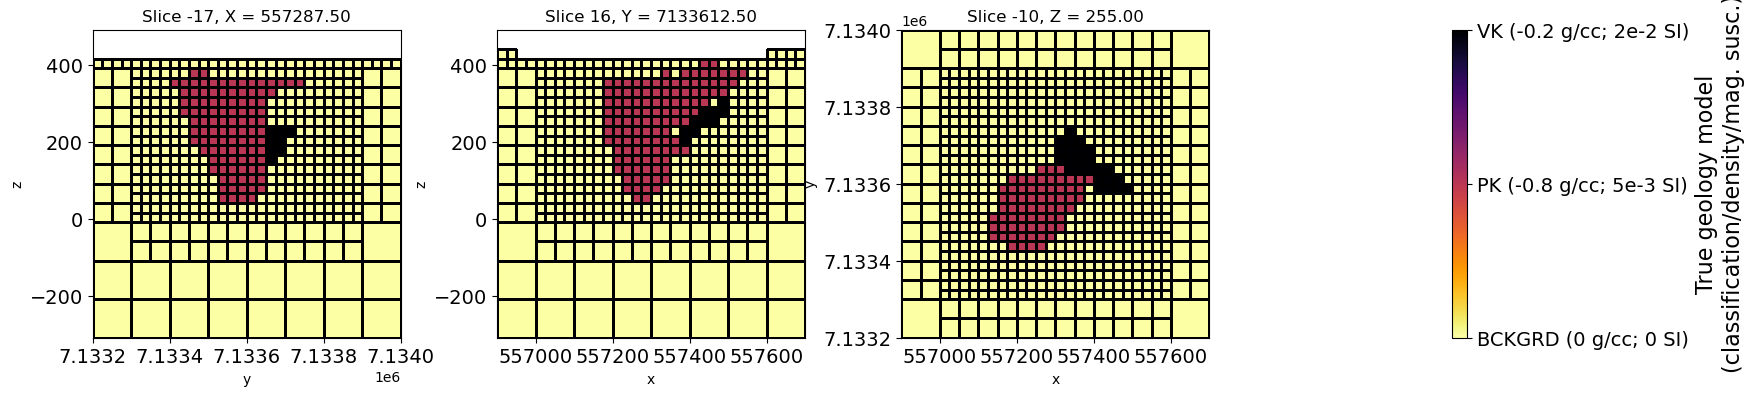

   saved to: /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/gravity_data.obs
Download completed!


   saved to: /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/magnetic_data.obs
Download completed!


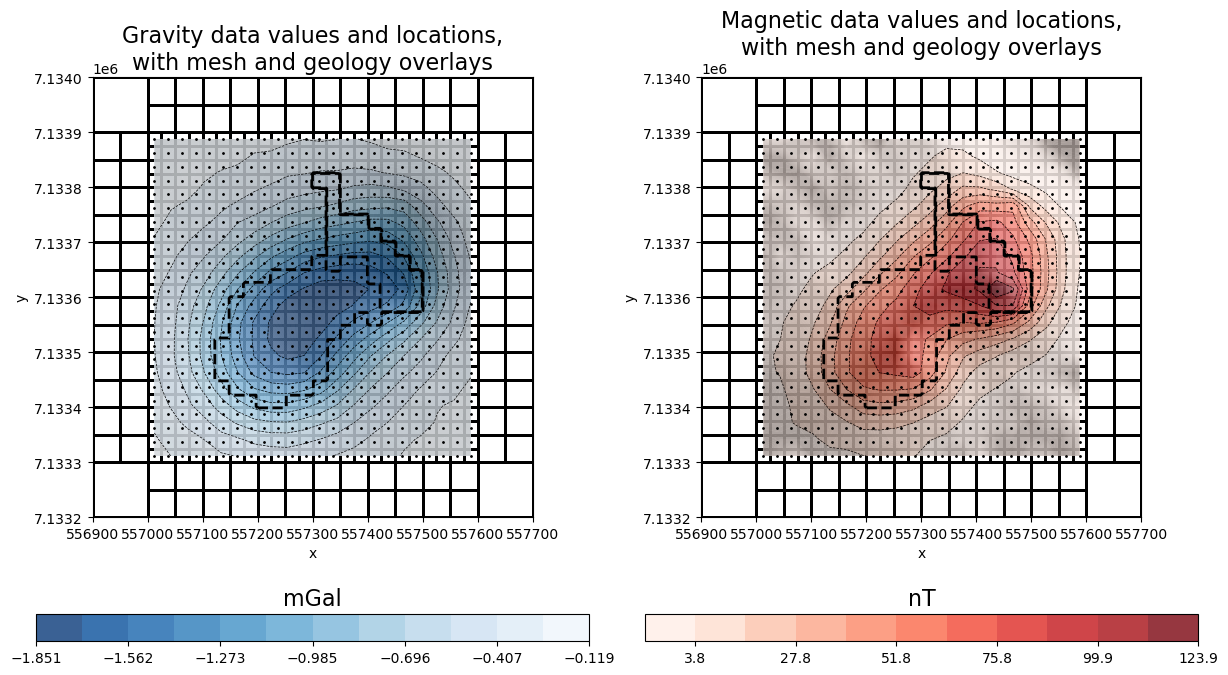

   saved to: /home/ssoler/git/user-tutorials/notebooks/12-pgi-inversion/CDED_Lake_warp.xyz
Download completed!


In [3]:
# Load Mesh
mesh_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/mesh_tutorial.ubc"
)
mesh = TreeMesh.read_UBC(mesh_file)

# Load True geological model for comparison with inversion result
true_geology_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/geology_true.mod"
)
true_geology = mesh.read_model_UBC(true_geology_file)

# Plot true geology model
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ticksize, labelsize = 14, 16
for _, axx in enumerate(ax):
    axx.set_aspect(1)
    axx.tick_params(labelsize=ticksize)
mesh.plot_slice(
    true_geology,
    normal="X",
    ax=ax[0],
    ind=-17,
    clim=[0, 2],
    pcolor_opts={"cmap": "inferno_r"},
    grid=True,
)
mesh.plot_slice(
    true_geology,
    normal="Y",
    ax=ax[1],
    clim=[0, 2],
    pcolor_opts={"cmap": "inferno_r"},
    grid=True,
)
geoplot = mesh.plot_slice(
    true_geology,
    normal="Z",
    ax=ax[2],
    clim=[0, 2],
    ind=-10,
    pcolor_opts={"cmap": "inferno_r"},
    grid=True,
)
geocb = plt.colorbar(geoplot[0], cax=ax[3], ticks=[0, 1, 2])
geocb.set_label(
    "True geology model\n(classification/density/mag. susc.)", fontsize=labelsize
)
geocb.set_ticklabels(
    ["BCKGRD (0 g/cc; 0 SI)", "PK (-0.8 g/cc; 5e-3 SI)", "VK (-0.2 g/cc; 2e-2 SI)"]
)
geocb.ax.tick_params(labelsize=ticksize)
ax[3].set_aspect(10)
plt.show()

# Load geophysical data
data_grav_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/gravity_data.obs"
)
data_grav = io_utils.read_grav3d_ubc(data_grav_file)
data_mag_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/magnetic_data.obs"
)
data_mag = io_utils.read_mag3d_ubc(data_mag_file)

# plot data and mesh
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.reshape(-1)
plt.gca().set_aspect("equal")
plt.gca().set_xlim(
    [
        data_mag.survey.receiver_locations[:, 0].min(),
        data_mag.survey.receiver_locations[:, 0].max(),
    ],
)
plt.gca().set_ylim(
    [
        data_mag.survey.receiver_locations[:, 1].min(),
        data_mag.survey.receiver_locations[:, 1].max(),
    ],
)
mesh.plot_slice(
    np.ones(mesh.nC),
    normal="Z",
    ind=int(-10),
    grid=True,
    pcolor_opts={"cmap": "Greys"},
    ax=ax[0],
)
mm = utils.plot2Ddata(
    data_grav.survey.receiver_locations,
    -data_grav.dobs,
    ax=ax[0],
    level=True,
    nx=20,
    ny=20,
    dataloc=True,
    ncontour=12,
    shade=True,
    contourOpts={"cmap": "Blues_r", "alpha": 0.8},
    levelOpts={"colors": "k", "linewidths": 0.5, "linestyles": "dashed"},
)
ax[0].set_aspect(1)
ax[0].set_title(
    "Gravity data values and locations,\nwith mesh and geology overlays", fontsize=16
)
plt.colorbar(mm[0], cax=ax[2], orientation="horizontal")
ax[2].set_aspect(0.05)
ax[2].set_title("mGal", fontsize=16)
mesh.plot_slice(
    np.ones(mesh.nC),
    normal="Z",
    ind=int(-10),
    grid=True,
    pcolor_opts={"cmap": "Greys"},
    ax=ax[1],
)
mm = utils.plot2Ddata(
    data_mag.survey.receiver_locations,
    data_mag.dobs,
    ax=ax[1],
    level=True,
    nx=20,
    ny=20,
    dataloc=True,
    ncontour=11,
    shade=True,
    contourOpts={"cmap": "Reds", "alpha": 0.8},
    levelOpts={"colors": "k", "linewidths": 0.5, "linestyles": "dashed"},
)
ax[1].set_aspect(1)
ax[1].set_title(
    "Magnetic data values and locations,\nwith mesh and geology overlays", fontsize=16
)
plt.colorbar(mm[0], cax=ax[3], orientation="horizontal")
ax[3].set_aspect(0.05)
ax[3].set_title("nT", fontsize=16)
# overlay true geology model for comparison
indz = -9
indslicezplot = mesh.gridCC[:, 2] == mesh.cell_centers_z[indz]
for i in range(2):
    utils.plot2Ddata(
        mesh.gridCC[indslicezplot][:, [0, 1]],
        true_geology[indslicezplot],
        nx=200,
        ny=200,
        contourOpts={"alpha": 0},
        clim=[0, 2],
        ax=ax[i],
        level=True,
        ncontour=2,
        levelOpts={"colors": "k", "linewidths": 2, "linestyles": "--"},
        method="nearest",
    )
plt.subplots_adjust(hspace=-0.25, wspace=0.1)
plt.show()

# Load Topo
topo_file = io_utils.download(
    "https://storage.googleapis.com/simpeg/pgi_tutorial_assets/CDED_Lake_warp.xyz"
)
topo = np.genfromtxt(topo_file, skip_header=1)
# find the active cells
actv = active_from_xyz(mesh, topo, "CC")
# Create active map to go from reduce set to full
ndv = np.nan
actvMap = maps.InjectActiveCells(mesh, actv, ndv)
nactv = int(actv.sum())

# Create simulations and data misfits
# Wires mapping
wires = maps.Wires(("den", actvMap.nP), ("sus", actvMap.nP))
gravmap = actvMap * wires.den
magmap = actvMap * wires.sus
idenMap = maps.IdentityMap(nP=nactv)
# Grav problem
simulation_grav = pf.gravity.simulation.Simulation3DIntegral(
    survey=data_grav.survey,
    mesh=mesh,
    rhoMap=wires.den,
    ind_active=actv,
)
dmis_grav = data_misfit.L2DataMisfit(data=data_grav, simulation=simulation_grav)
# Mag problem
simulation_mag = pf.magnetics.simulation.Simulation3DIntegral(
    survey=data_mag.survey,
    mesh=mesh,
    chiMap=wires.sus,
    ind_active=actv,
)
dmis_mag = data_misfit.L2DataMisfit(data=data_mag, simulation=simulation_mag)

## Create a joint Data Misfit



In [4]:
# Joint data misfit
dmis = 0.5 * dmis_grav + 0.5 * dmis_mag

# initial model
m0 = np.r_[-1e-4 * np.ones(actvMap.nP), 1e-4 * np.ones(actvMap.nP)]

## Inversion with full petrophysical information




## Create and plot a petrophysical GMM with full information

The GMM is our representation of the petrophysical and geological information.
Here, we focus on the petrophysical aspect, with the means and covariances of
the physical properties of each rock unit.
To generate the data above, the PK unit was populated with a density contrast
of -0.8 g/cc and a magnetic susceptibility of 0.005 SI. The properties of the
HK unit were set at -0.2 g/cc and 0.02 SI. The covariances matrices are set
so that we assume petrophysical noise levels of around 0.05 g/cc and 0.001 SI
for both unit. Finally the background unit is set at null contrasts (0 g/cc
0 SI) with a petrophysical noise level of half of the above.




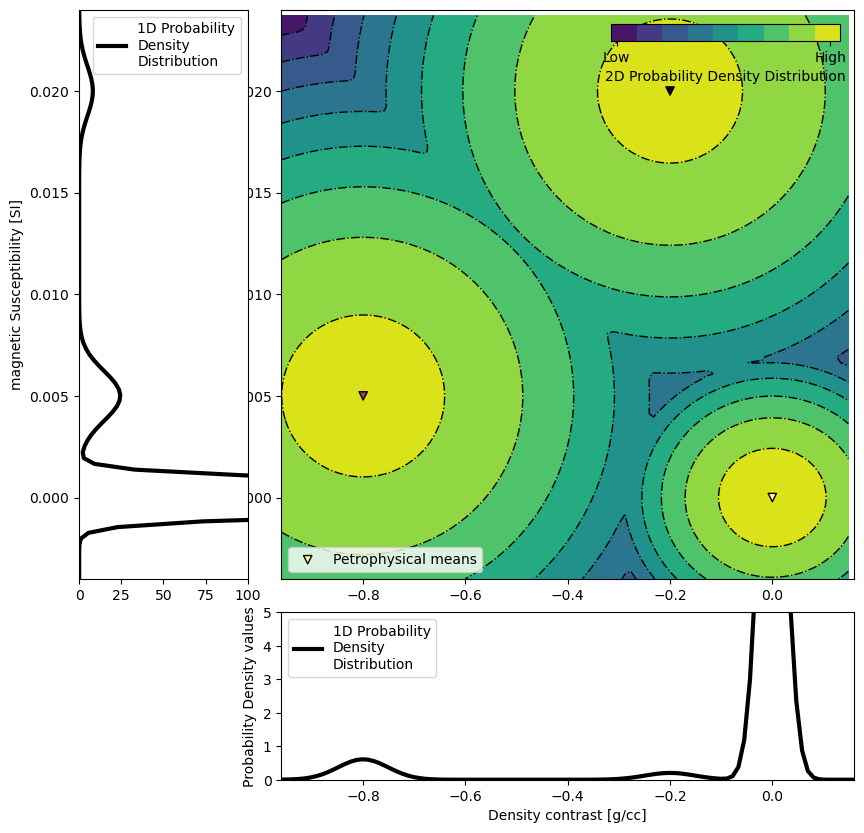

In [5]:
gmmref = utils.WeightedGaussianMixture(
    n_components=3,  # number of rock units: bckgrd, PK, HK
    mesh=mesh,  # inversion mesh
    actv=actv,  # actv cells
    covariance_type="diag",  # diagonal covariances
)
# required: initialization with fit
# fake random samples, size of the mesh, number of physical properties: 2 (density and mag.susc)
gmmref.fit(np.random.randn(nactv, 2))
# set parameters manually
# set phys. prop means for each unit
gmmref.means_ = np.c_[
    [0.0, 0.0],  # BCKGRD density contrast and mag. susc
    [-0.8, 0.005],  # PK
    [-0.2, 0.02],  # HK
].T
# set phys. prop covariances for each unit
gmmref.covariances_ = np.array(
    [[6e-04, 3.175e-07], [2.4e-03, 1.5e-06], [2.4e-03, 1.5e-06]]
)
# important after setting cov. manually: compute precision matrices and cholesky
gmmref.compute_clusters_precisions()
# set global proportions; low-impact as long as not 0 or 1 (total=1)
gmmref.weights_ = np.r_[0.9, 0.075, 0.025]

# Plot the 2D GMM
ax = gmmref.plot_pdf(flag2d=True)
ax[0].set_xlabel("Density contrast [g/cc]")
ax[0].set_ylim([0, 5])
ax[2].set_ylabel("magnetic Susceptibility [SI]")
ax[2].set_xlim([0, 100])
plt.show()

## Create PGI regularization




In [6]:
# Sensitivity weighting
wr_grav = np.sum(simulation_grav.G**2.0, axis=0) ** 0.5 / (mesh.cell_volumes[actv])
wr_grav = wr_grav / np.max(wr_grav)

wr_mag = np.sum(simulation_mag.G**2.0, axis=0) ** 0.5 / (mesh.cell_volumes[actv])
wr_mag = wr_mag / np.max(wr_mag)

# create joint PGI regularization with smoothness
reg = regularization.PGI(
    gmmref=gmmref,
    mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap, idenMap],
    active_cells=actv,
    alpha_pgi=1.0,
    alpha_x=1.0,
    alpha_y=1.0,
    alpha_z=1.0,
    alpha_xx=0.0,
    alpha_yy=0.0,
    alpha_zz=0.0,
    # use the classification of the initial model (here, all background unit)
    # as initial reference model
    reference_model=utils.mkvc(
        gmmref.means_[gmmref.predict(m0.reshape(actvMap.nP, -1))]
    ),
    weights_list=[wr_grav, wr_mag],  # weights each phys. prop. by correct sensW
)

## Inverse problem with full petrophysical information





                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    


Alpha scales: [92154.18186342454, 0.0, 62129.66856426274, 0.0, 123237.8070080113, 0.0, 9174395.807251327, 0.0, 7390472.616876792, 0.0, 16909805.762840346, 0.0]


<class 'SimPEG.regularization.pgi.PGIsmallness'>
Initial data misfit scales:  [0.98271129 0.01728871]


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  4.24e-06  4.28e+06  9.99e+04  4.28e+06    2.17e+02      0              


geophys. misfits: 250142.8 (target 576.0 [False]); 48524.5 (target 576.0 [False]) | smallness misfit: 326666.0 (target: 23438.0 [False])
Beta cooling evaluation: progress: [250142.8  48524.5]; minimum progress targets: [3470231.3  572697.8]


mref changed in  890  places


   1  4.24e-06  2.47e+05  3.08e+08  2.48e+05    1.40e+01      0              


geophys. misfits: 8947.5 (target 576.0 [False]); 1643.0 (target 576.0 [False]) | smallness misfit: 50683.0 (target: 23438.0 [False])
Beta cooling evaluation: progress: [8947.5 1643. ]; minimum progress targets: [200114.3  38819.6]


mref changed in  25  places


   2  4.24e-06  8.82e+03  1.46e+08  9.44e+03    2.06e+01      0              


geophys. misfits: 4817.8 (target 576.0 [False]); 324.3 (target 576.0 [True]) | smallness misfit: 46471.9 (target: 23438.0 [False])
Updating scaling for data misfits by  1.7759447678104279
New scales: [0.99019097 0.00980903]
Beta cooling evaluation: progress: [4817.8  324.3]; minimum progress targets: [7158.  1314.4]


mref changed in  2  places


   3  4.24e-06  4.77e+03  1.38e+08  5.36e+03    2.08e+01      0   Skip BFGS  


geophys. misfits: 708.6 (target 576.0 [False]); 211.4 (target 576.0 [True]) | smallness misfit: 44473.1 (target: 23438.0 [False])
Updating scaling for data misfits by  2.7251607534191207
New scales: [0.99637808 0.00362192]
Beta cooling evaluation: progress: [708.6 211.4]; minimum progress targets: [3854.2  691.2]


mref changed in  1  places


   4  4.24e-06  7.07e+02  1.40e+08  1.30e+03    2.16e+01      0   Skip BFGS  


geophys. misfits: 406.6 (target 576.0 [True]); 319.8 (target 576.0 [True]) | smallness misfit: 43836.2 (target: 23438.0 [False])
Beta cooling evaluation: progress: [406.6 319.8]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  1.608798811746842


mref changed in  1  places


   5  4.24e-06  4.06e+02  1.92e+08  1.22e+03    3.57e+01      0   Skip BFGS  


geophys. misfits: 445.6 (target 576.0 [True]); 569.3 (target 576.0 [True]) | smallness misfit: 35551.7 (target: 23438.0 [False])
Beta cooling evaluation: progress: [445.6 569.3]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  1.8537332731126763


mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells


   6  4.24e-06  4.46e+02  1.94e+08  1.27e+03    4.45e+01      0              


geophys. misfits: 399.0 (target 576.0 [True]); 522.8 (target 576.0 [True]) | smallness misfit: 29872.9 (target: 23438.0 [False])
Beta cooling evaluation: progress: [399.  522.8]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  2.359253288620419


mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells


   7  4.24e-06  3.99e+02  2.21e+08  1.33e+03    2.29e+01      0              


geophys. misfits: 422.3 (target 576.0 [True]); 714.4 (target 576.0 [False]) | smallness misfit: 25614.7 (target: 23438.0 [False])
Updating scaling for data misfits by  1.3640585456466676
New scales: [0.99506599 0.00493401]
Beta cooling evaluation: progress: [422.3 714.4]; minimum progress targets: [691.2 691.2]
Decreasing beta to counter data misfit increase.


mref changed in  0  places


   8  2.12e-06  4.24e+02  2.09e+08  8.66e+02    3.34e+01      0              


geophys. misfits: 338.5 (target 576.0 [True]); 372.5 (target 576.0 [True]) | smallness misfit: 27688.2 (target: 23438.0 [False])
Beta cooling evaluation: progress: [338.5 372.5]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  3.831105909042013


mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells


   9  2.12e-06  3.39e+02  3.39e+08  1.06e+03    2.23e+01      0              


geophys. misfits: 387.5 (target 576.0 [True]); 554.1 (target 576.0 [True]) | smallness misfit: 24240.9 (target: 23438.0 [False])
Beta cooling evaluation: progress: [387.5 554.1]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  4.838400854198931


mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells


  10  2.12e-06  3.88e+02  3.65e+08  1.16e+03    2.48e+01      0              


geophys. misfits: 420.6 (target 576.0 [True]); 531.3 (target 576.0 [True]) | smallness misfit: 22617.6 (target: 23438.0 [True])
All targets have been reached
Beta cooling evaluation: progress: [420.6 531.3]; minimum progress targets: [691.2 691.2]
Warming alpha_pgi to favor clustering:  5.935953245782225


mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 4.2752e+05
0 : |xc-x_last| = 4.1436e-01 <= tolX*(1+|x0|) = 1.0153e-01
0 : |proj(x-g)-x|    = 2.4827e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.4827e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      30    <= iter          =     11
------------------------- DONE! -------------------------


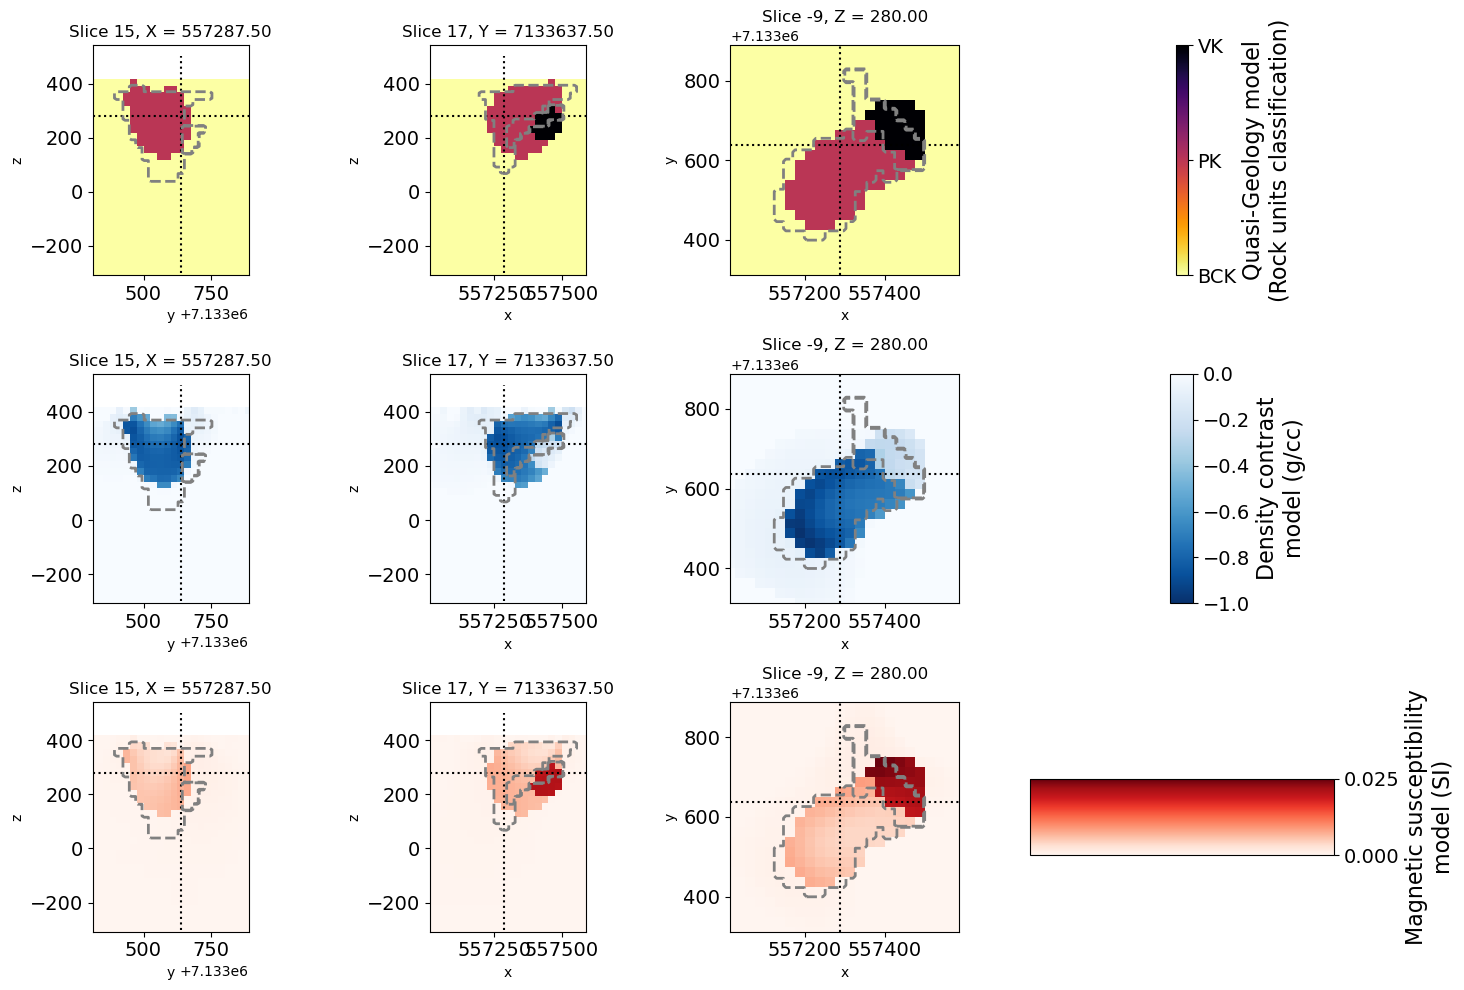

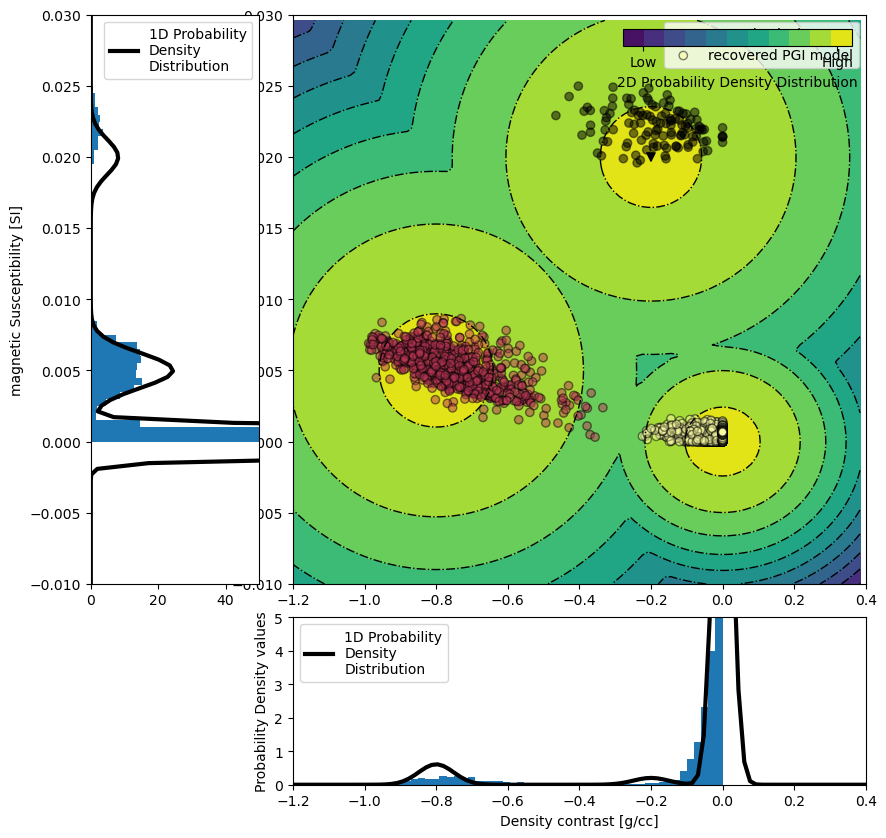

In [7]:
# Directives
# Add directives to the inversion
# ratio to use for each phys prop. smoothness in each direction;
# roughly the ratio of the order of magnitude of each phys. prop.
alpha0_ratio = np.r_[
    1e-4 * np.ones(len(reg.objfcts[1].objfcts[1:])),
    1e-4 * 100.0 * np.ones(len(reg.objfcts[2].objfcts[1:])),
]
Alphas = directives.AlphasSmoothEstimate_ByEig(alpha0_ratio=alpha0_ratio, verbose=True)
# initialize beta and beta/alpha_pgi schedule
beta = directives.BetaEstimate_ByEig(beta0_ratio=1e-2)
betaIt = directives.PGI_BetaAlphaSchedule(
    verbose=True,
    coolingFactor=2.0,
    tolerance=0.2,
    progress=0.2,
)
# geophy. and petro. target misfits
targets = directives.MultiTargetMisfits(
    verbose=True,
)
# add learned mref in smooth once stable
MrefInSmooth = directives.PGI_AddMrefInSmooth(
    wait_till_stable=True,
    verbose=True,
)
# update the parameters in smallness (L2-approx of PGI)
update_smallness = directives.PGI_UpdateParameters(
    update_gmm=False  # keep GMM model fixed
)
# pre-conditioner
update_Jacobi = directives.UpdatePreconditioner()
# iteratively balance the scaling of the data misfits
scaling_init = directives.ScalingMultipleDataMisfits_ByEig(chi0_ratio=[1.0, 100.0])
scale_schedule = directives.JointScalingSchedule(verbose=True)

# Create inverse problem
# Optimization
# set lower and upper bounds
lowerbound = np.r_[-2.0 * np.ones(actvMap.nP), 0.0 * np.ones(actvMap.nP)]
upperbound = np.r_[0.0 * np.ones(actvMap.nP), 1e-1 * np.ones(actvMap.nP)]
opt = optimization.ProjectedGNCG(
    maxIter=30,
    lower=lowerbound,
    upper=upperbound,
    maxIterLS=20,
    maxIterCG=100,
    tolCG=1e-4,
)
# create inverse problem
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
inv = inversion.BaseInversion(
    invProb,
    # directives: evaluate alphas (and data misfits scales) before beta
    directiveList=[
        Alphas,
        scaling_init,
        beta,
        update_smallness,
        targets,
        scale_schedule,
        betaIt,
        MrefInSmooth,
        update_Jacobi,
    ],
)

# invert
pgi_model = inv.run(m0)

# Extract the results
density_model = gravmap * pgi_model
magsus_model = magmap * pgi_model
quasi_geology_model = actvMap * reg.objfcts[0].compute_quasi_geology_model()

# Plot the result with full petrophysical information
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
for _, axx in enumerate(ax):
    for _, axxx in enumerate(axx):
        axxx.set_aspect(1)
        axxx.tick_params(labelsize=ticksize)

indx = 15
indy = 17
indz = -9
# geology model
mesh.plot_slice(
    quasi_geology_model,
    normal="X",
    ax=ax[0, 0],
    clim=[0, 2],
    ind=indx,
    pcolor_opts={"cmap": "inferno_r"},
)
mesh.plot_slice(
    quasi_geology_model,
    normal="Y",
    ax=ax[0, 1],
    clim=[0, 2],
    ind=indy,
    pcolor_opts={"cmap": "inferno_r"},
)
geoplot = mesh.plot_slice(
    quasi_geology_model,
    normal="Z",
    ax=ax[0, 2],
    clim=[0, 2],
    ind=indz,
    pcolor_opts={"cmap": "inferno_r"},
)
geocb = plt.colorbar(geoplot[0], cax=ax[0, 3], ticks=[0, 1, 2])
geocb.set_ticklabels(["BCK", "PK", "VK"])
geocb.set_label("Quasi-Geology model\n(Rock units classification)", fontsize=16)
ax[0, 3].set_aspect(10)

# gravity model
mesh.plot_slice(
    density_model,
    normal="X",
    ax=ax[1, 0],
    clim=[-1, 0],
    ind=indx,
    pcolor_opts={"cmap": "Blues_r"},
)
mesh.plot_slice(
    density_model,
    normal="Y",
    ax=ax[1, 1],
    clim=[-1, 0],
    ind=indy,
    pcolor_opts={"cmap": "Blues_r"},
)
denplot = mesh.plot_slice(
    density_model,
    normal="Z",
    ax=ax[1, 2],
    clim=[-1, 0],
    ind=indz,
    pcolor_opts={"cmap": "Blues_r"},
)
dencb = plt.colorbar(denplot[0], cax=ax[1, 3])
dencb.set_label("Density contrast\nmodel (g/cc)", fontsize=16)
ax[1, 3].set_aspect(10)

# magnetic model
mesh.plot_slice(
    magsus_model,
    normal="X",
    ax=ax[2, 0],
    clim=[0, 0.025],
    ind=indx,
    pcolor_opts={"cmap": "Reds"},
)
mesh.plot_slice(
    magsus_model,
    normal="Y",
    ax=ax[2, 1],
    clim=[0, 0.025],
    ind=indy,
    pcolor_opts={"cmap": "Reds"},
)
susplot = mesh.plot_slice(
    magsus_model,
    normal="Z",
    ax=ax[2, 2],
    clim=[0, 0.025],
    ind=indz,
    pcolor_opts={"cmap": "Reds"},
)
suscb = plt.colorbar(susplot[0], cax=ax[2, 3])
suscb.set_label("Magnetic susceptibility\nmodel (SI)", fontsize=16)
ax[2, 3].set_aspect(10)

# overlay true geology model for comparison
indslicexplot = mesh.gridCC[:, 0] == mesh.cell_centers_x[indx]
indsliceyplot = mesh.gridCC[:, 1] == mesh.cell_centers_y[indy]
indslicezplot = mesh.gridCC[:, 2] == mesh.cell_centers_z[indz]
for i in range(3):
    for j, (plane, indd) in enumerate(
        zip([[1, 2], [0, 2], [0, 1]], [indslicexplot, indsliceyplot, indslicezplot])
    ):
        utils.plot2Ddata(
            mesh.gridCC[indd][:, plane],
            true_geology[indd],
            nx=100,
            ny=100,
            contourOpts={"alpha": 0},
            clim=[0, 2],
            ax=ax[i, j],
            level=True,
            ncontour=2,
            levelOpts={"colors": "grey", "linewidths": 2, "linestyles": "--"},
            method="nearest",
        )

# plot the locations of the cross-sections
for i in range(3):
    ax[i, 0].plot(
        mesh.cell_centers_y[indy] * np.ones(2), [-300, 500], c="k", linestyle="dotted"
    )
    ax[i, 0].plot(
        [
            data_mag.survey.receiver_locations[:, 1].min(),
            data_mag.survey.receiver_locations[:, 1].max(),
        ],
        mesh.cell_centers_z[indz] * np.ones(2),
        c="k",
        linestyle="dotted",
    )
    ax[i, 0].set_xlim(
        [
            data_mag.survey.receiver_locations[:, 1].min(),
            data_mag.survey.receiver_locations[:, 1].max(),
        ],
    )

    ax[i, 1].plot(
        mesh.cell_centers_x[indx] * np.ones(2), [-300, 500], c="k", linestyle="dotted"
    )
    ax[i, 1].plot(
        [
            data_mag.survey.receiver_locations[:, 0].min(),
            data_mag.survey.receiver_locations[:, 0].max(),
        ],
        mesh.cell_centers_z[indz] * np.ones(2),
        c="k",
        linestyle="dotted",
    )
    ax[i, 1].set_xlim(
        [
            data_mag.survey.receiver_locations[:, 0].min(),
            data_mag.survey.receiver_locations[:, 0].max(),
        ],
    )

    ax[i, 2].plot(
        mesh.cell_centers_x[indx] * np.ones(2),
        [
            data_mag.survey.receiver_locations[:, 1].min(),
            data_mag.survey.receiver_locations[:, 1].max(),
        ],
        c="k",
        linestyle="dotted",
    )
    ax[i, 2].plot(
        [
            data_mag.survey.receiver_locations[:, 0].min(),
            data_mag.survey.receiver_locations[:, 0].max(),
        ],
        mesh.cell_centers_y[indy] * np.ones(2),
        c="k",
        linestyle="dotted",
    )
    ax[i, 2].set_xlim(
        [
            data_mag.survey.receiver_locations[:, 0].min(),
            data_mag.survey.receiver_locations[:, 0].max(),
        ],
    )
    ax[i, 2].set_ylim(
        [
            data_mag.survey.receiver_locations[:, 1].min(),
            data_mag.survey.receiver_locations[:, 1].max(),
        ],
    )

plt.tight_layout()
plt.show()

# Plot the 2D GMM
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((4, 4), (3, 1), colspan=3)
ax1 = plt.subplot2grid((4, 4), (0, 1), colspan=3, rowspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3)
ax = [ax0, ax1, ax2]
reg.objfcts[0].gmm.plot_pdf(flag2d=True, ax=ax, padding=0.5)
ax[0].set_xlabel("Density contrast [g/cc]")
ax[0].set_ylim([0, 5])
ax[2].set_xlim([0, 50])
ax[2].set_ylabel("magnetic Susceptibility [SI]")
ax[1].scatter(
    density_model[actv],
    magsus_model[actv],
    c=quasi_geology_model[actv],
    cmap="inferno_r",
    edgecolors="k",
    label="recovered PGI model",
    alpha=0.5,
)
ax[1].legend()
ax[0].hist(density_model[actv], density=True, bins=50)
ax[2].hist(magsus_model[actv], density=True, bins=50, orientation="horizontal")
plt.show()